In [1]:
# from urllib.request import urlretrieve

# def load_data(download=True):
#     if download:
#         data_path, _ = urlretrieve(
#             "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
#             "./adult.csv"
#         )
#         print("adult dataset download")


# load_data()

downloaded


<!-- https://blog.csdn.net/weixin_39858881/article/details/107235037 -->

1. 连续性数值特征，如age,最好处理
2. 二分类文本信息，二分法处理
3. 多类别文本信息

- age:连续性数值变量；可能的处理方法：分年龄段；
- workcass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov,State-gov, Without-pay, Never-worked.
 ：雇主类型，多类别，一般处理方法：化为数值类别，比如以上八个可以分别表示为1-8（仅为示例，本文并不推荐）；
- fnlwgt: 连续性数值变量；人口普查员认为观察值的人数。该变量在本文不被使用，笔者认为该特征并不重要。
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm,Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th,Preschool.受教育程度，多类别数据，处理方法同workcass；
- education-num: 连续性数值变量，受教育水平年限，一般来讲，该值越大，工资越高；
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated,Widowed, Married-spouse-absent, Married-AF-spouse.婚姻状况，多类别数据；
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial,Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical,Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv,Armed-Forces.职业，多类别数据；
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative,Unmarried.群体性关系，多类别数据；
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.种族，多类别数据，虽然美国反对种族歧视，但是实际上这个在区分美国工资的时候蛮重要；
- sex: Female, Male.性别，最简单的二分法（0&1）；
- capital-gain: 资本收益，连续数值；
- capital-loss: 资本损失，连续数值；
- hours-per-week: 工作时间，连续数值；
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada,Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China,Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico,Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti,Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia,El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.国籍，多类别数据；
- result：结果：“>50K”或“<=50K”，二分类数据，也是本文机器学习的目的（0&1）；

In [1]:
# 数据处理  
import time, datetime, math, random  
from io import StringIO  
import numpy as np  
import pandas as pd  
from sklearn.model_selection import train_test_split  
# 可视化  
import matplotlib.pyplot as plt  # 绘图  
import missingno  # 缺失值可视化  
import seaborn as sns  # 绘图库  
from pandas.plotting import scatter_matrix #绘制散布矩阵图  
# 分类模型  
# import sklearn.ensemble as ske # 包含了一套分类算法  
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier  
from sklearn.tree import DecisionTreeClassifier   
from sklearn.ensemble import AdaBoostClassifier   
from sklearn.ensemble import VotingClassifier   
from sklearn.svm import SVC  
# 自动调参器 - 随机探索  
import scipy.stats as st  
from scipy.stats import randint as sp_randint # 随机变量  
from sklearn.model_selection import RandomizedSearchCV # 自动调参工具（随机采样）  
# 计算模型评价指标  
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc  
from sklearn.metrics import precision_recall_curve  
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score 
# 控制提示信息  
import warnings  
warnings.filterwarnings('ignore')  
# 便于在notebook中显示图形并可省略plt.show()，简化代码  
%matplotlib inline  



In [2]:
headers = [
    "age",
    "workclass",
    "final-weight",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "country",
    "income-level",
]  # 定义数据表头即参数名

adult_data = pd.read_csv(
    "adult/adult.data",
    header=None,
    names=headers,
    sep=",\s",
    na_values=["?"],
    engine="python",
)  # 导入数据集给出的训练集

adult_test = pd.read_csv(
    "adult/adult.test",
    header=None,
    names=headers,
    sep=",\s",
    na_values=["?"],
    engine="python",
    skiprows=1,
)  # 导入数据集给出的测试集
dataset = pd.concat([adult_data, adult_test])

dataset.reset_index(inplace=True, drop=True)

<Axes: >

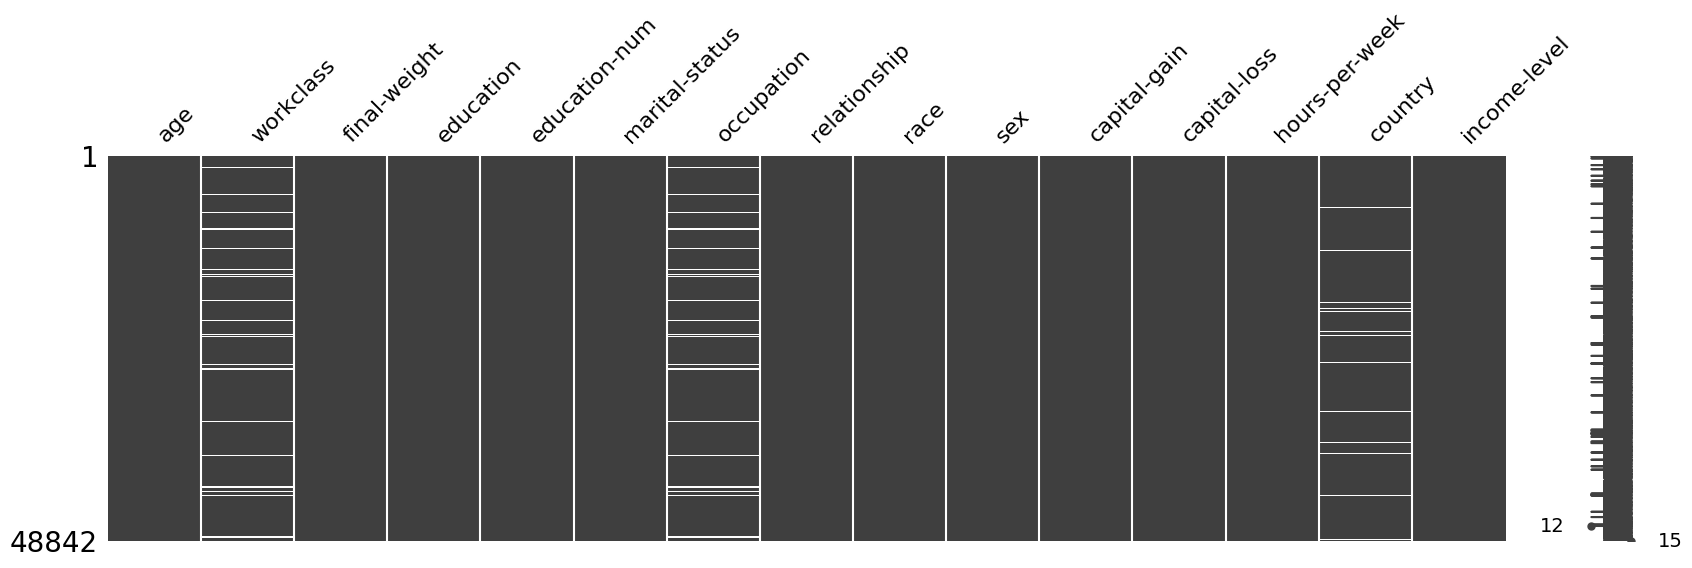

In [3]:
# 绘制缺失值矩阵图
missingno.matrix(dataset, figsize=(20, 5))

<Axes: >

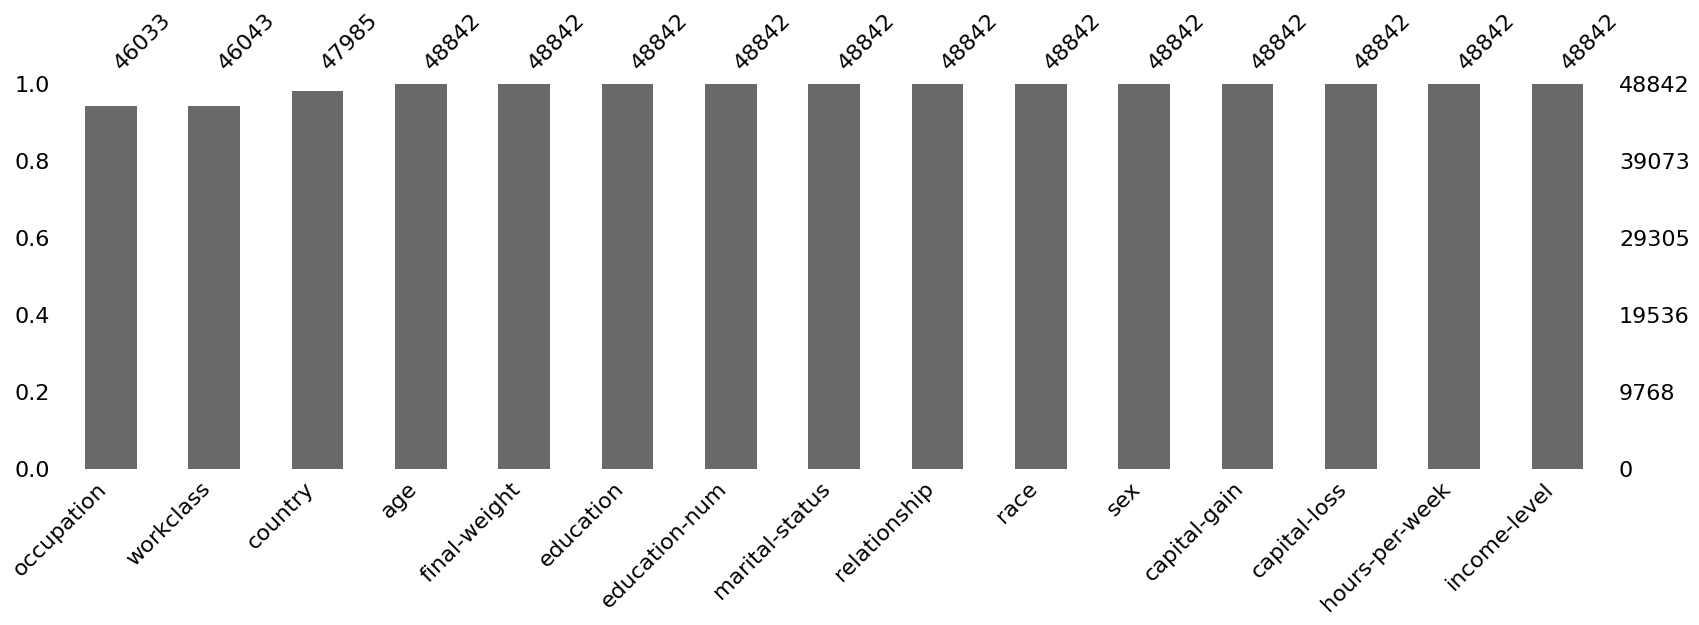

In [4]:
missingno.bar(dataset, sort="ascending", figsize=(20, 5))

通过缺失值柱状图可以看出，工作类型（workclass）、职业（occupation）和国籍（country）均存在不同程度的缺失，其余指标无缺失值，其中工作类型缺失值最多，其次为职业（occupation）和国籍（country）。

忽略含有缺失值的样本对整体数据影响很小，故采取直接删除含有缺失值样本的方法对缺失值进行处理，并对处理后的数据进行描述。

In [5]:
dataset.dropna(axis=0, how="any", inplace=True)
dataset.describe(include="all")

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
count,45222.000000,45222,4.522200e+04,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,4
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,NaN,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,22654
mean,38.547941,NaN,1.897347e+05,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,1.056392e+05,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,1.349200e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.173882e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783160e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.379260e+05,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [6]:
# 处理年收入指标  
dataset.loc[dataset['income-level'] == '>50K.', 'income-level'] = '>50K'  
dataset.loc[dataset['income-level'] == '<=50K.', 'income-level'] = '<=50K'  


# 删除无用的final-weight指标  
dataset = dataset.drop(['final-weight'],axis=1)

In [7]:
dataset.describe(include="all")

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
count,45222.000000,45222,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,34014
mean,38.547941,NaN,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


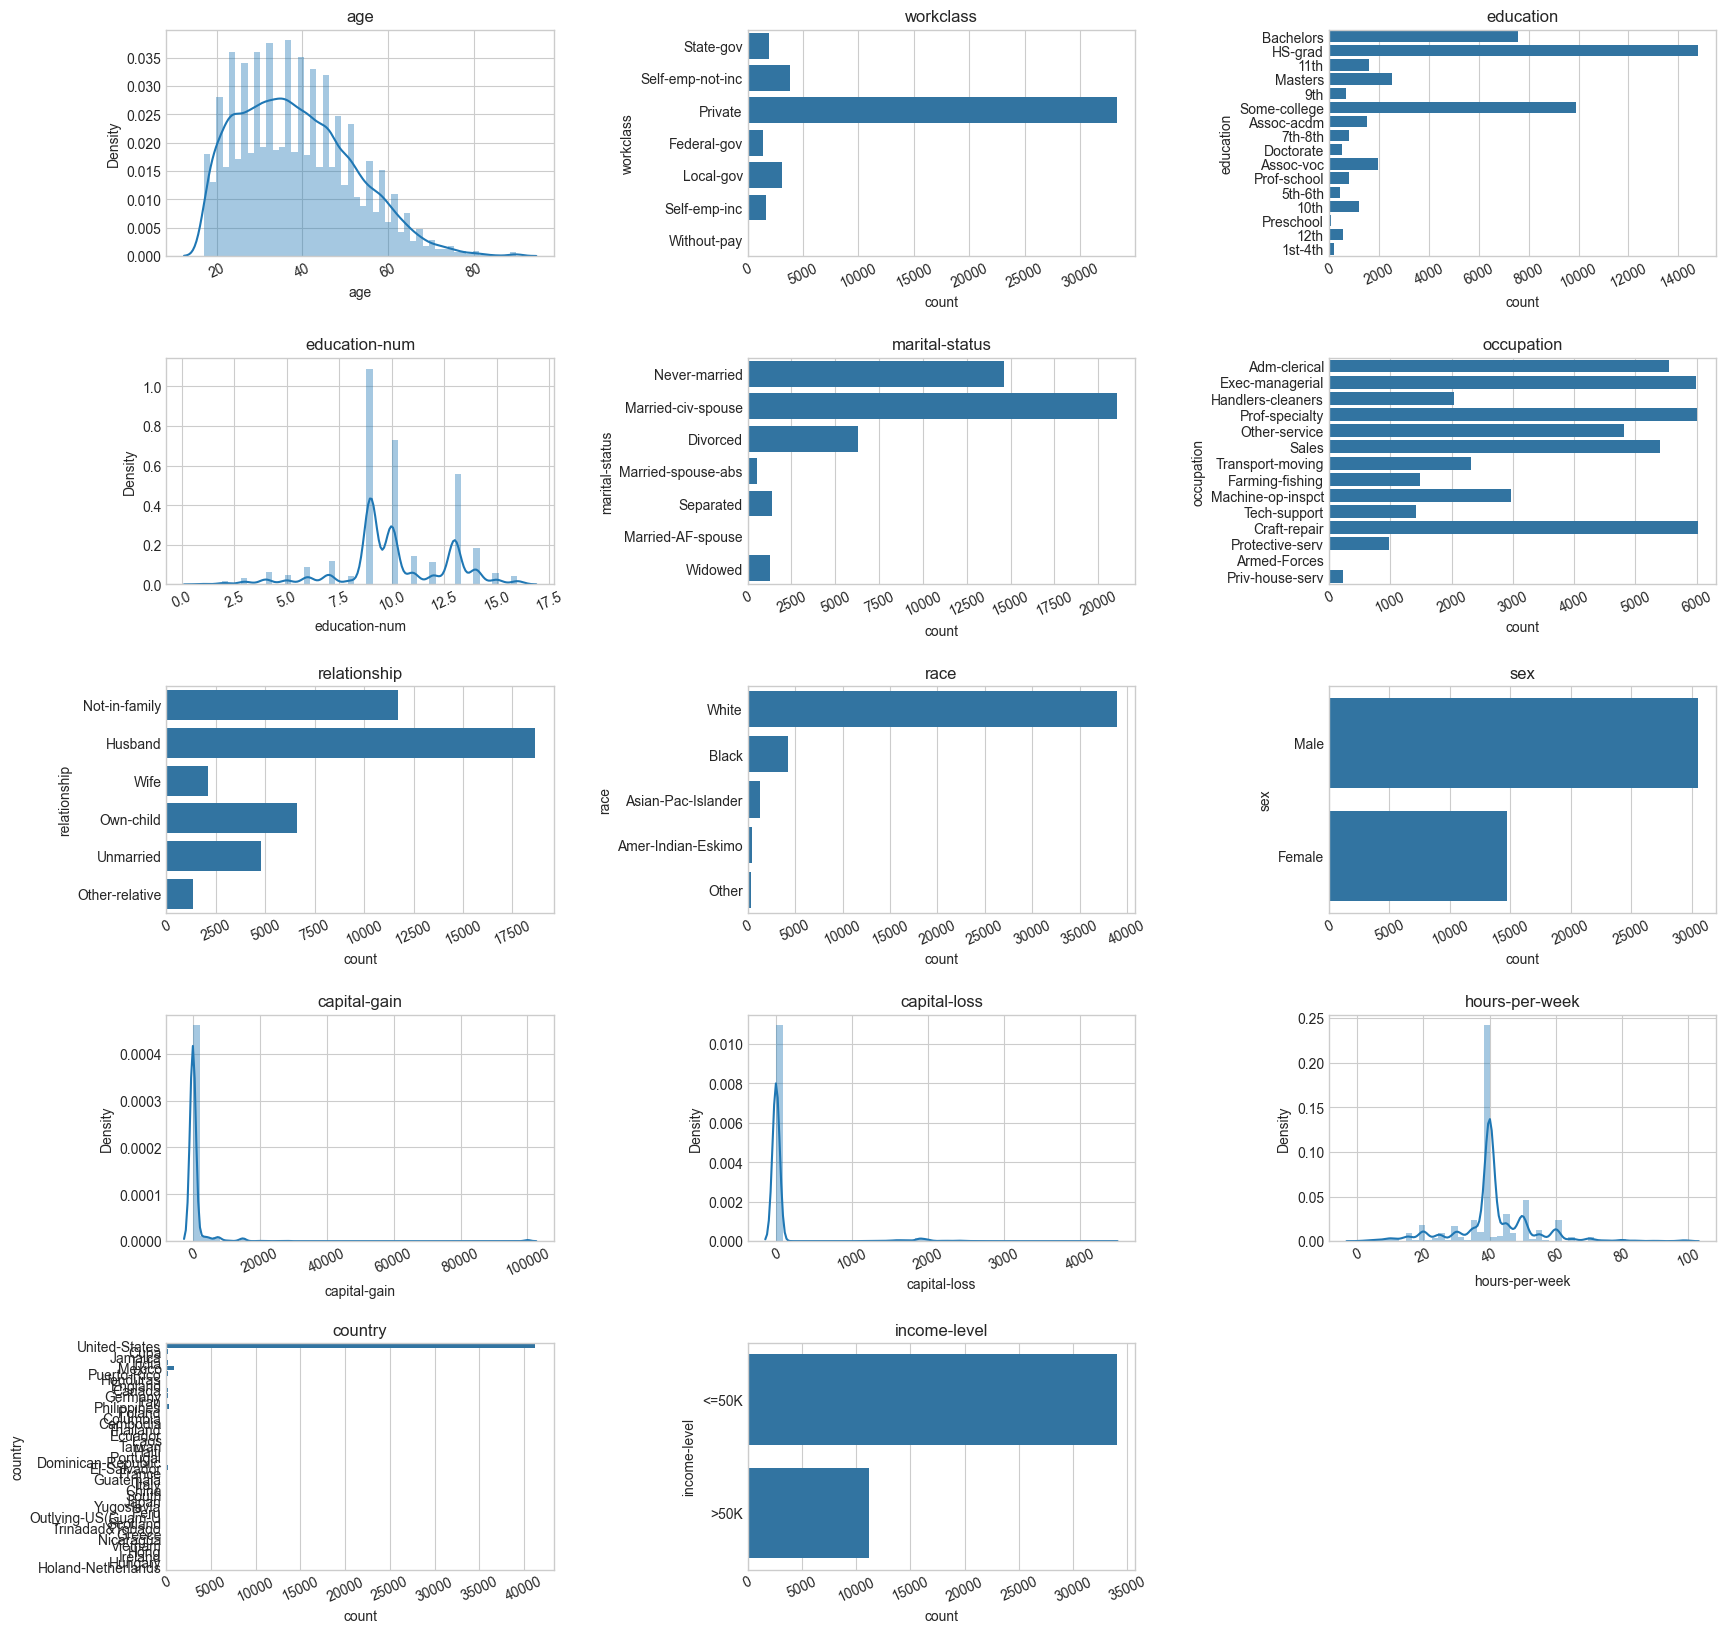

In [8]:
# 绘制每个变量的分布状况
def plot_distribution(dataset, cols, width, height, hspace, wspace):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace
    )
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object_:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)


plot_distribution(dataset, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

### work class

<Axes: xlabel='count', ylabel='workclass'>

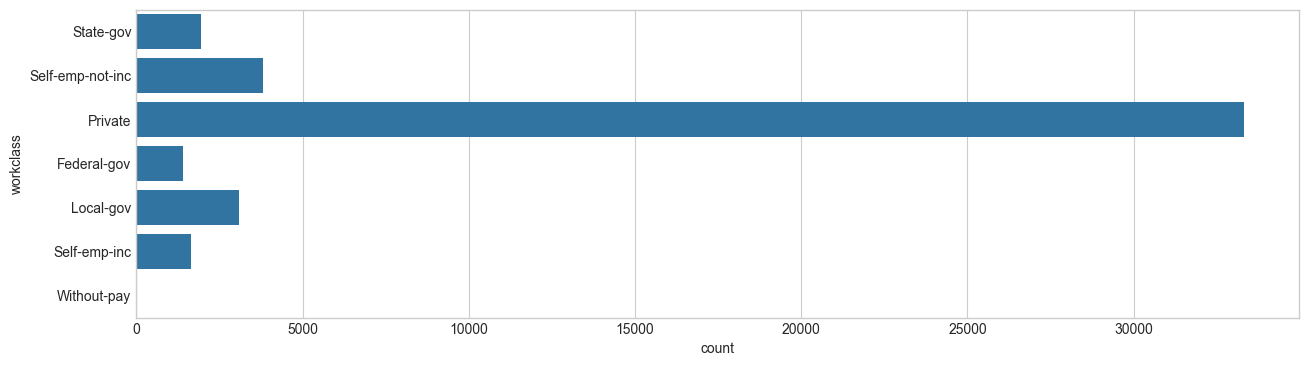

In [9]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(15, 4))
sns.countplot(y="workclass", data=dataset)

私营工作在样本中占比较大，不工作和无收入工作样本数量极小，结合实际情况，将其归纳为5类。

<Axes: xlabel='count', ylabel='workclass'>

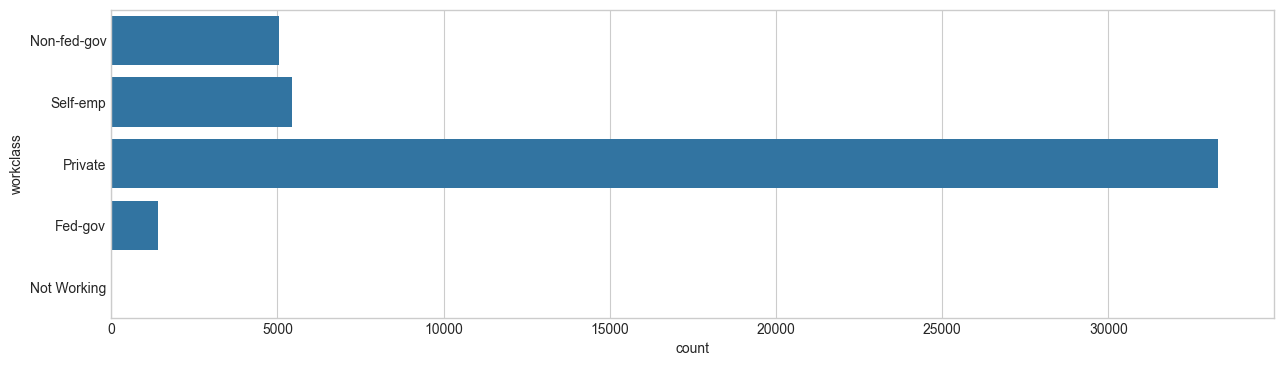

In [10]:
dataset.loc[dataset['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'  
dataset.loc[dataset['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'  
dataset.loc[dataset['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'  
dataset.loc[dataset['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'  
dataset.loc[dataset['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'  
dataset.loc[dataset['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'  
dataset.loc[dataset['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'  
dataset.loc[dataset['workclass'] == ' Private', 'workclass'] = ' Private'  

plt.style.use('seaborn-whitegrid')  
fig = plt.figure(figsize=(15, 4))   
sns.countplot(y="workclass", data=dataset)


## occupation

本数据集中职业共有14种类型如下：Tech-support（技术支持）, Craft-repair（手工艺维修）, Other-service（其他职业）,Sales（销售）, Exec-managerial（执行主管）, Prof-specialty（专业技术）,Handlers-cleaners（劳工保洁）, Machine-op-inspct（机械操作）, Adm-clerical（管理文书）,Farming-fishing（农业捕捞）, Transport-moving（运输）, Priv-house-serv（家政服务）,Protective-serv（保安）, Armed-Forces（军人）。

<Axes: xlabel='count', ylabel='occupation'>

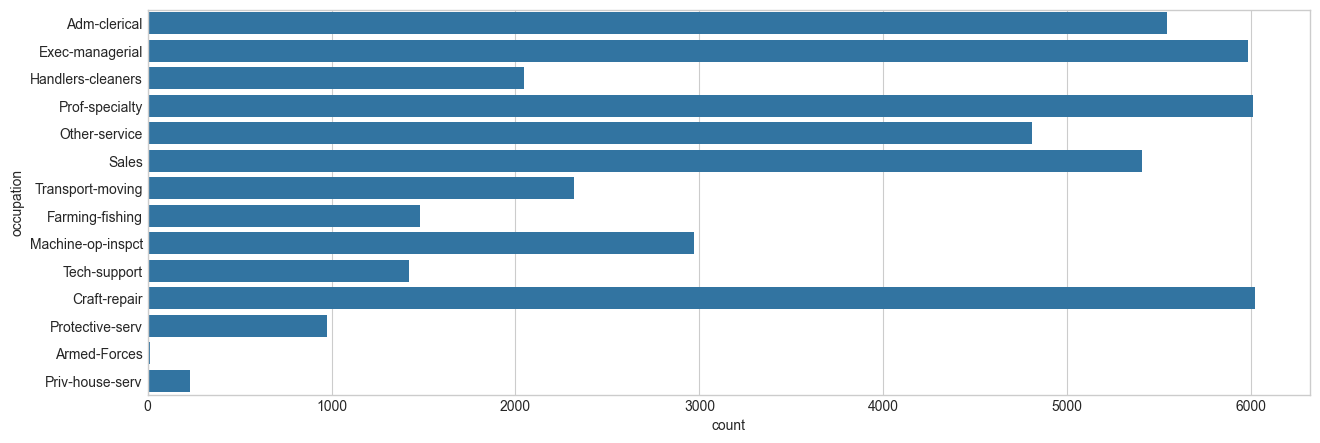

In [11]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(15, 5))
sns.countplot(y="occupation", data=dataset)

为便于后续分析，将其合并为6类。

<Axes: xlabel='count', ylabel='occupation'>

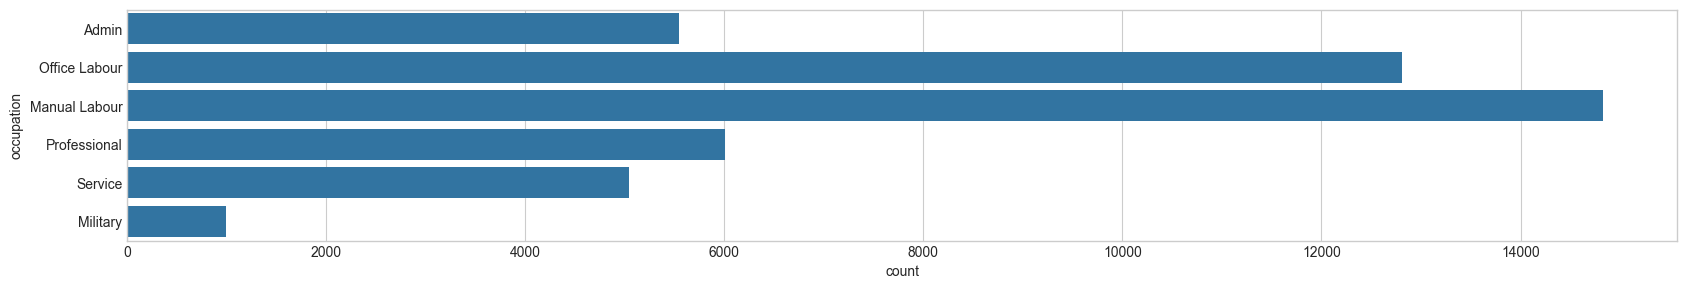

In [12]:
dataset.loc[dataset["occupation"] == "Adm-clerical", "occupation"] = "Admin"  # 行政文员
dataset.loc[dataset["occupation"] == "Armed-Forces", "occupation"] = "Military"  # 军队
dataset.loc[dataset["occupation"] == "Protective-serv", "occupation"] = (
    "Military"  # 军队
)
dataset.loc[dataset["occupation"] == "Craft-repair", "occupation"] = (
    "Manual Labour"  # 体力劳动者
)
dataset.loc[dataset["occupation"] == "Transport-moving", "occupation"] = (
    "Manual Labour"  # 体力劳动者
)
dataset.loc[dataset["occupation"] == "Farming-fishing", "occupation"] = (
    "Manual Labour"  # 体力劳动者
)
dataset.loc[dataset["occupation"] == "Handlers-cleaners", "occupation"] = (
    "Manual Labour"  # 体力劳动者
)
dataset.loc[dataset["occupation"] == "Machine-op-inspct", "occupation"] = (
    "Manual Labour"  # 体力劳动者
)
dataset.loc[dataset["occupation"] == "Exec-managerial", "occupation"] = (
    "Office Labour"  # 文书工作
)
dataset.loc[dataset["occupation"] == "Sales", "occupation"] = (
    "Office Labour"  # 文书工作
)
dataset.loc[dataset["occupation"] == "Tech-support", "occupation"] = (
    "Office Labour"  # 文书工作
)
dataset.loc[dataset["occupation"] == "Other-service", "occupation"] = (
    "Service"  # 服务人员
)
dataset.loc[dataset["occupation"] == "Priv-house-serv", "occupation"] = (
    "Service"  # 服务人员
)
dataset.loc[dataset["occupation"] == "Prof-specialty", "occupation"] = (
    "Professional"  # 技术人员
)

plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(20, 3))
sns.countplot(y="occupation", data=dataset)

## country
数据说明里共列出41个国家和地区，除美国外大部分国家和地区的样本都很少，故在此按照地域对这些国家和地区进行合并。

<Axes: xlabel='count', ylabel='country'>

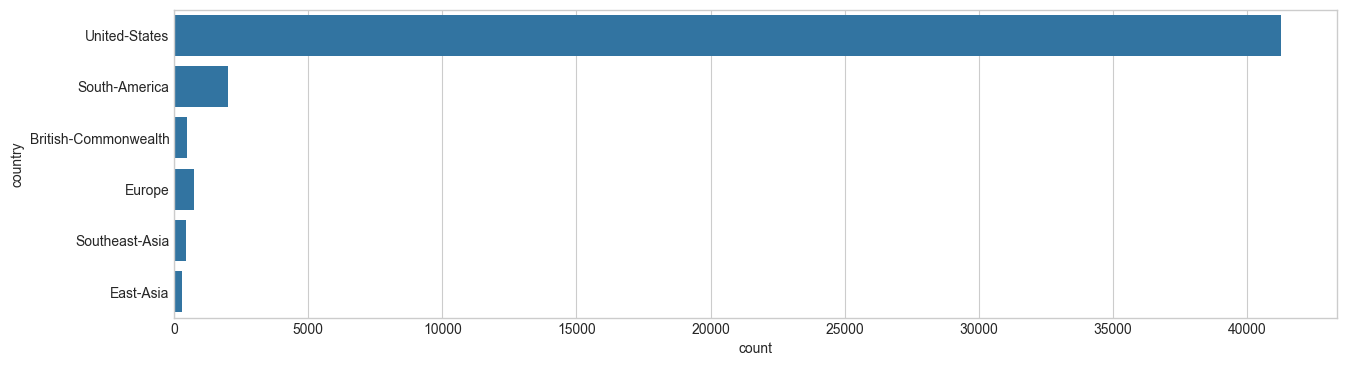

In [13]:
dataset.loc[dataset["country"] == "China", "country"] = "East-Asia"
dataset.loc[dataset["country"] == "Hong", "country"] = "East-Asia"
dataset.loc[dataset["country"] == "Taiwan", "country"] = "East-Asia"
dataset.loc[dataset["country"] == "Japan", "country"] = "East-Asia"

dataset.loc[dataset["country"] == "Thailand", "country"] = "Southeast-Asia"
dataset.loc[dataset["country"] == "Vietnam", "country"] = "Southeast-Asia"
dataset.loc[dataset["country"] == "Laos", "country"] = "Southeast-Asia"
dataset.loc[dataset["country"] == "Philippines", "country"] = "Southeast-Asia"
dataset.loc[dataset["country"] == "Cambodia", "country"] = "Southeast-Asia"

dataset.loc[dataset["country"] == "Columbia", "country"] = "South-America"
dataset.loc[dataset["country"] == "Cuba", "country"] = "South-America"
dataset.loc[dataset["country"] == "Dominican-Republic", "country"] = "South-America"
dataset.loc[dataset["country"] == "Ecuador", "country"] = "South-America"
dataset.loc[dataset["country"] == "Guatemala", "country"] = "South-America"
dataset.loc[dataset["country"] == "El-Salvador", "country"] = "South-America"
dataset.loc[dataset["country"] == "Haiti", "country"] = "South-America"
dataset.loc[dataset["country"] == "Honduras", "country"] = "South-America"
dataset.loc[dataset["country"] == "Mexico", "country"] = "South-America"
dataset.loc[dataset["country"] == "Nicaragua", "country"] = "South-America"
dataset.loc[dataset["country"] == "Outlying-US(Guam-USVI-etc)", "country"] = (
    "South-America"
)
dataset.loc[dataset["country"] == "Peru", "country"] = "South-America"
dataset.loc[dataset["country"] == "Jamaica", "country"] = "South-America"
dataset.loc[dataset["country"] == "Puerto-Rico", "country"] = "South-America"
dataset.loc[dataset["country"] == "Trinadad&Tobago", "country"] = "South-America"

dataset.loc[dataset["country"] == "Canada", "country"] = "British-Commonwealth"
dataset.loc[dataset["country"] == "England", "country"] = "British-Commonwealth"
dataset.loc[dataset["country"] == "India", "country"] = "British-Commonwealth"
dataset.loc[dataset["country"] == "Ireland", "country"] = "British-Commonwealth"
dataset.loc[dataset["country"] == "Scotland", "country"] = "British-Commonwealth"

dataset.loc[dataset["country"] == "France", "country"] = "Europe"
dataset.loc[dataset["country"] == "Germany", "country"] = "Europe"
dataset.loc[dataset["country"] == "Italy", "country"] = "Europe"
dataset.loc[dataset["country"] == "Holand-Netherlands", "country"] = "Europe"
dataset.loc[dataset["country"] == "Greece", "country"] = "Europe"
dataset.loc[dataset["country"] == "Hungary", "country"] = "Europe"
dataset.loc[dataset["country"] == "Iran", "country"] = "Europe"
dataset.loc[dataset["country"] == "Yugoslavia", "country"] = "Europe"
dataset.loc[dataset["country"] == "Poland", "country"] = "Europe"
dataset.loc[dataset["country"] == "Portugal", "country"] = "Europe"
dataset.loc[dataset["country"] == "South", "country"] = "Europe"

dataset.loc[dataset["country"] == "United-States", "country"] = "United-States"

plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(15, 4))
sns.countplot(y="country", data=dataset)

将国家合并为地区后，虽然与美国相比仍差异较大，但是各类别样本数量更加均匀。


## education
受教育程度

<Axes: xlabel='count', ylabel='education'>

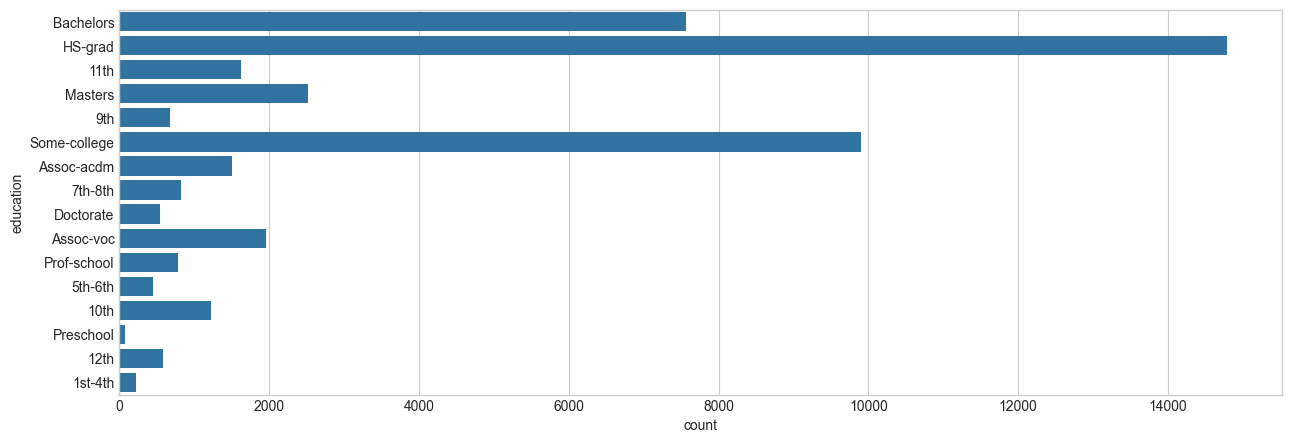

In [14]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(15, 5))
sns.countplot(y="education", data=dataset)

受教育程度类别多达16个，通过生成条形图可以看出低教育水平的各类别数量较少，故以高中为界，将其整合为一类（dropout），对两类高中（HS-Graduate）和两类专科（Associate）也进行合并。

<Axes: xlabel='count', ylabel='education'>

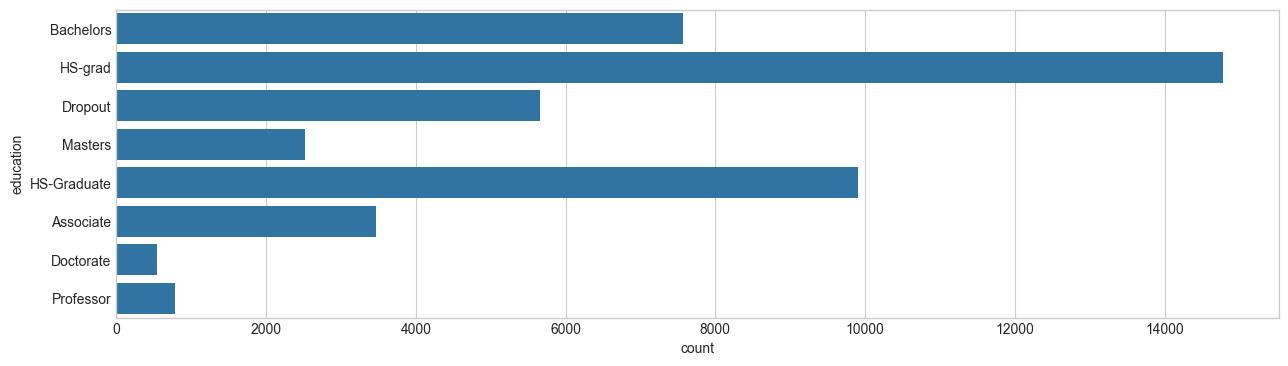

In [15]:
dataset.loc[dataset["education"] == "Preschool", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "1st-4th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "5th-6th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "7th-8th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "9th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "10th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "11th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "12th", "education"] = "Dropout"  # 退学
dataset.loc[dataset["education"] == "Assoc-acdm", "education"] = "Associate"  # 专科
dataset.loc[dataset["education"] == "Assoc-voc", "education"] = "Associate"  # 专科
dataset.loc[dataset["education"] == "HS-Grad", "education"] = "HS-Graduate"  # 高中
dataset.loc[dataset["education"] == "Some-college", "education"] = "HS-Graduate"  # 高中
dataset.loc[dataset["education"] == "Prof-school", "education"] = "Professor"  # 职业
dataset.loc[dataset["education"] == "Bachelors", "education"] = "Bachelors"  # 学士
dataset.loc[dataset["education"] == "Masters", "education"] = "Masters"  # 硕士
dataset.loc[dataset["education"] == "Doctorate", "education"] = "Doctorate"  # 博士

plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(15, 4))
sns.countplot(y="education", data=dataset)

## martial status
婚姻状态

<Axes: xlabel='count', ylabel='marital-status'>

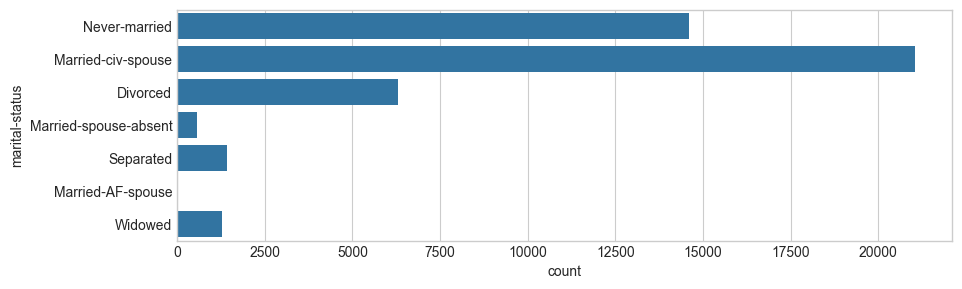

In [16]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10, 3))
sns.countplot(y="marital-status", data=dataset)

合并为4类：从未结婚、离异、分居和已婚。

<Axes: xlabel='count', ylabel='marital-status'>

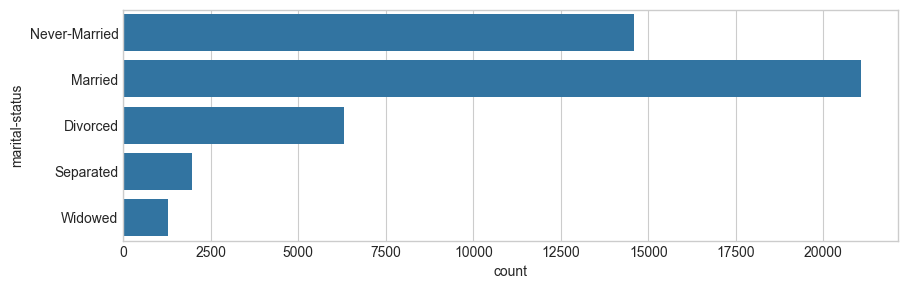

In [17]:
dataset.loc[dataset["marital-status"] == "Never-married", "marital-status"] = (
    "Never-Married"  # 从未结婚
)
dataset.loc[dataset["marital-status"] == "Divorced", "marital-status"] = (
    "Divorced"  # 离异
)
dataset.loc[dataset["marital-status"] == "Widowed", "marital-status"] = (
    "Widowed"  # 丧偶
)
dataset.loc[dataset["marital-status"] == "Married-spouse-absent", "marital-status"] = (
    "Separated"  # 分居
)
dataset.loc[dataset["marital-status"] == "Separated", "marital-status"] = (
    "Separated"  # 分居
)
dataset.loc[dataset["marital-status"] == "Married-AF-spouse", "marital-status"] = (
    "Married"  # 已婚
)
dataset.loc[dataset["marital-status"] == "Married-civ-spouse", "marital-status"] = (
    "Married"  # 已婚
)

plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(10, 3))
sns.countplot(y="marital-status", data=dataset)

## Check the distribution again

部分分类指标存在的类别过于复杂、部分类别样本数量过少的问题得到了一定程度的缓解。

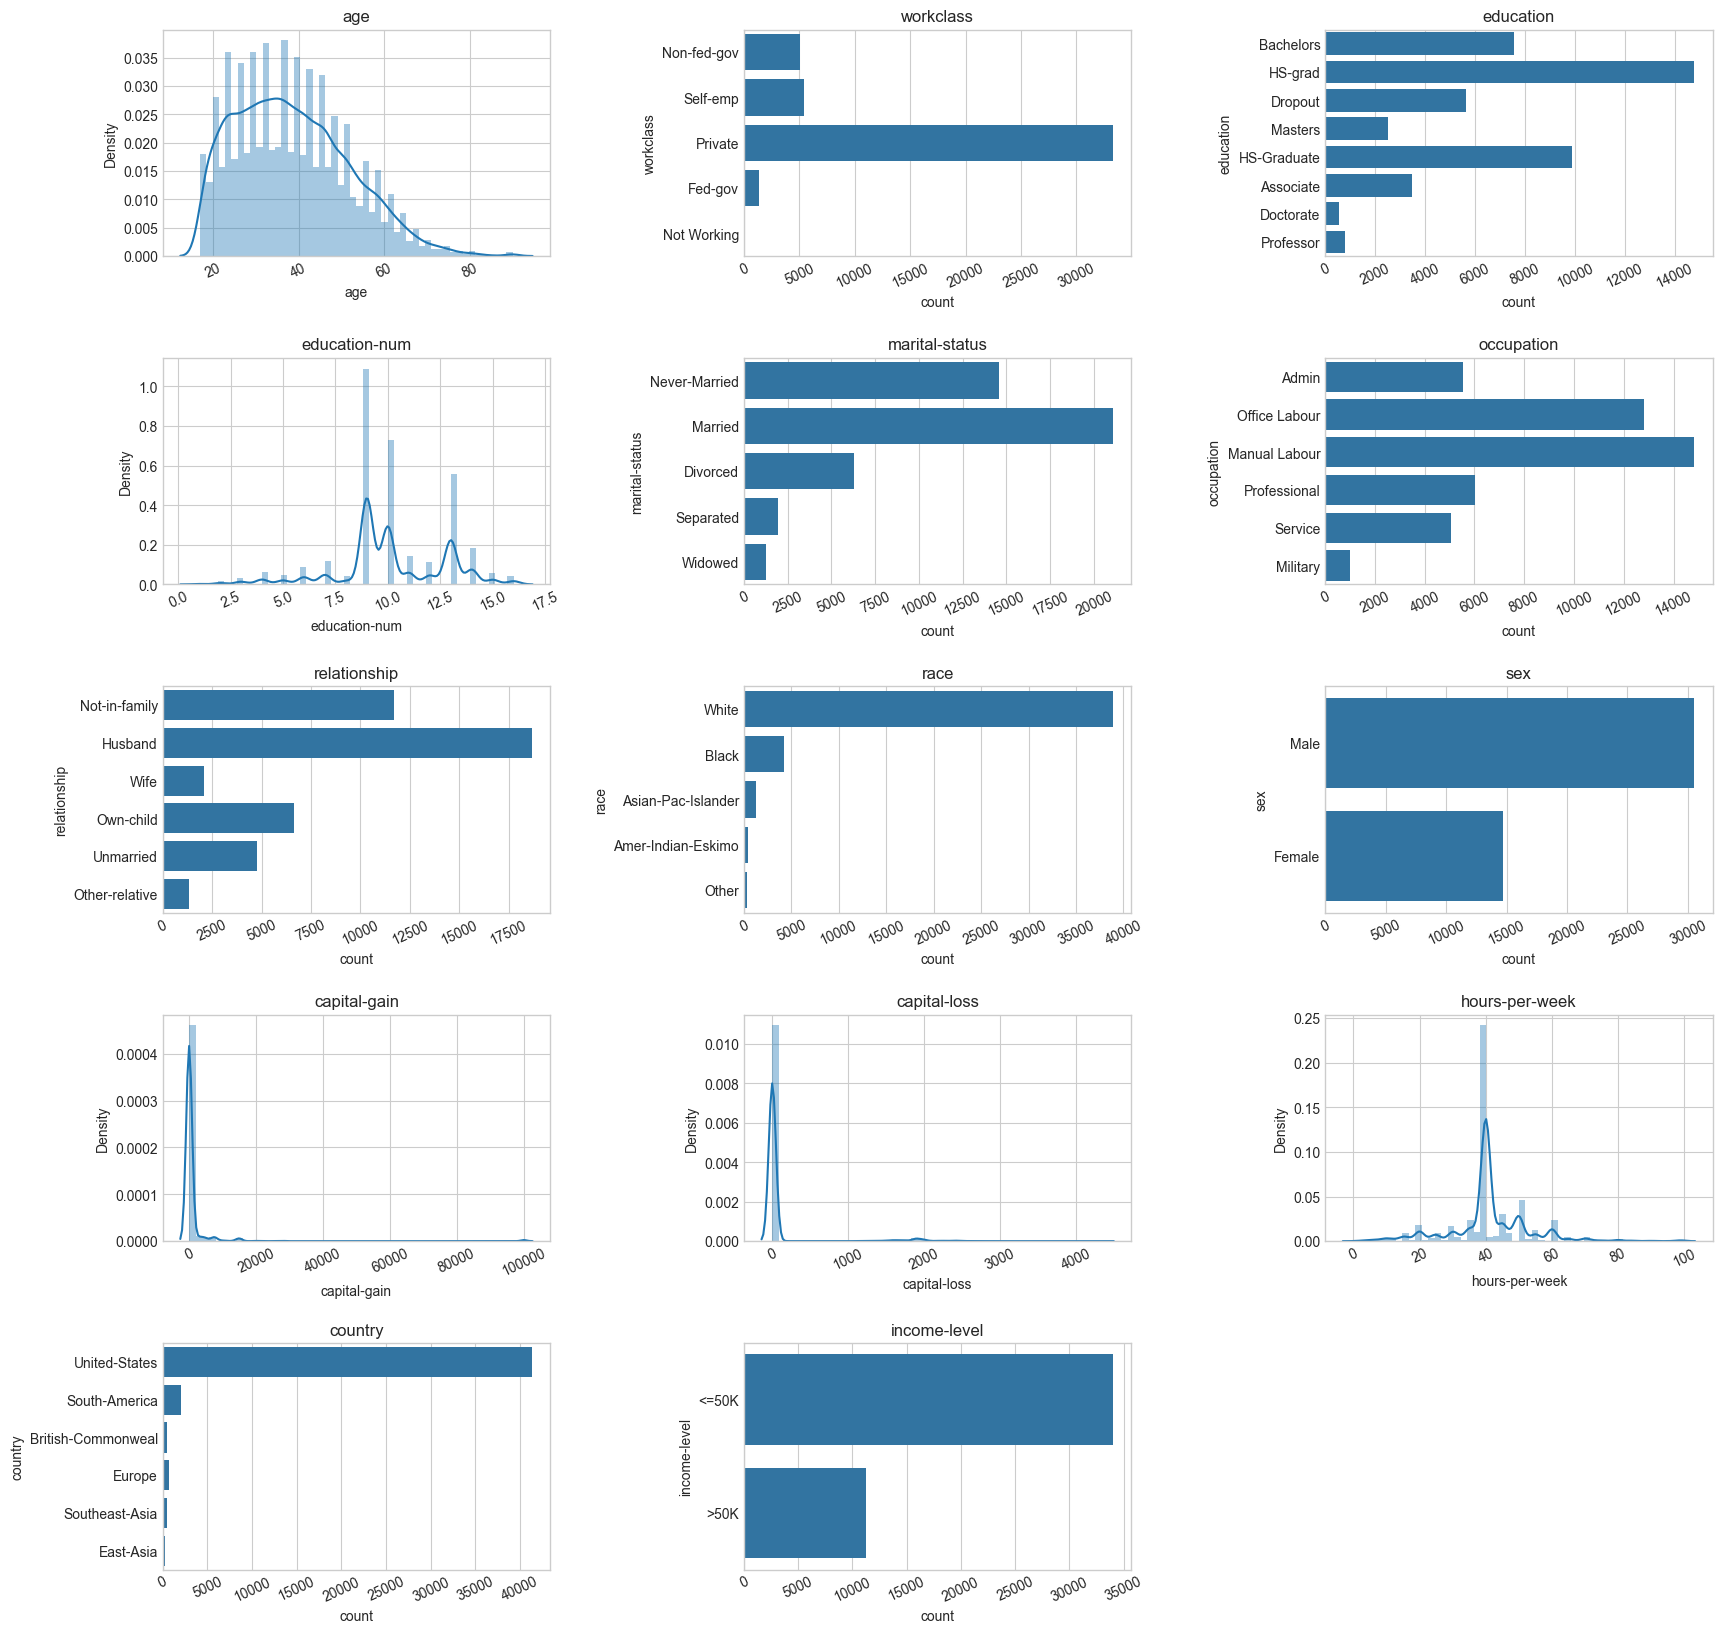

In [18]:
plot_distribution(dataset, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

## correlation
检查变量间相关关系

In [19]:
dataset_num = dataset.copy()  # 复制数据集

# categorical features -> factorize them
dataset_num["workclass"] = dataset_num["workclass"].factorize()[0]
dataset_num["education"] = dataset_num["education"].factorize()[0]
dataset_num["marital-status"] = dataset_num["marital-status"].factorize()[0]
dataset_num["occupation"] = dataset_num["occupation"].factorize()[0]
dataset_num["relationship"] = dataset_num["relationship"].factorize()[0]
dataset_num["race"] = dataset_num["race"].factorize()[0]
dataset_num["sex"] = dataset_num["sex"].factorize()[0]
dataset_num["country"] = dataset_num["country"].factorize()[0]
dataset_num["income-level"] = dataset_num["income-level"].factorize()[0]

<Axes: >

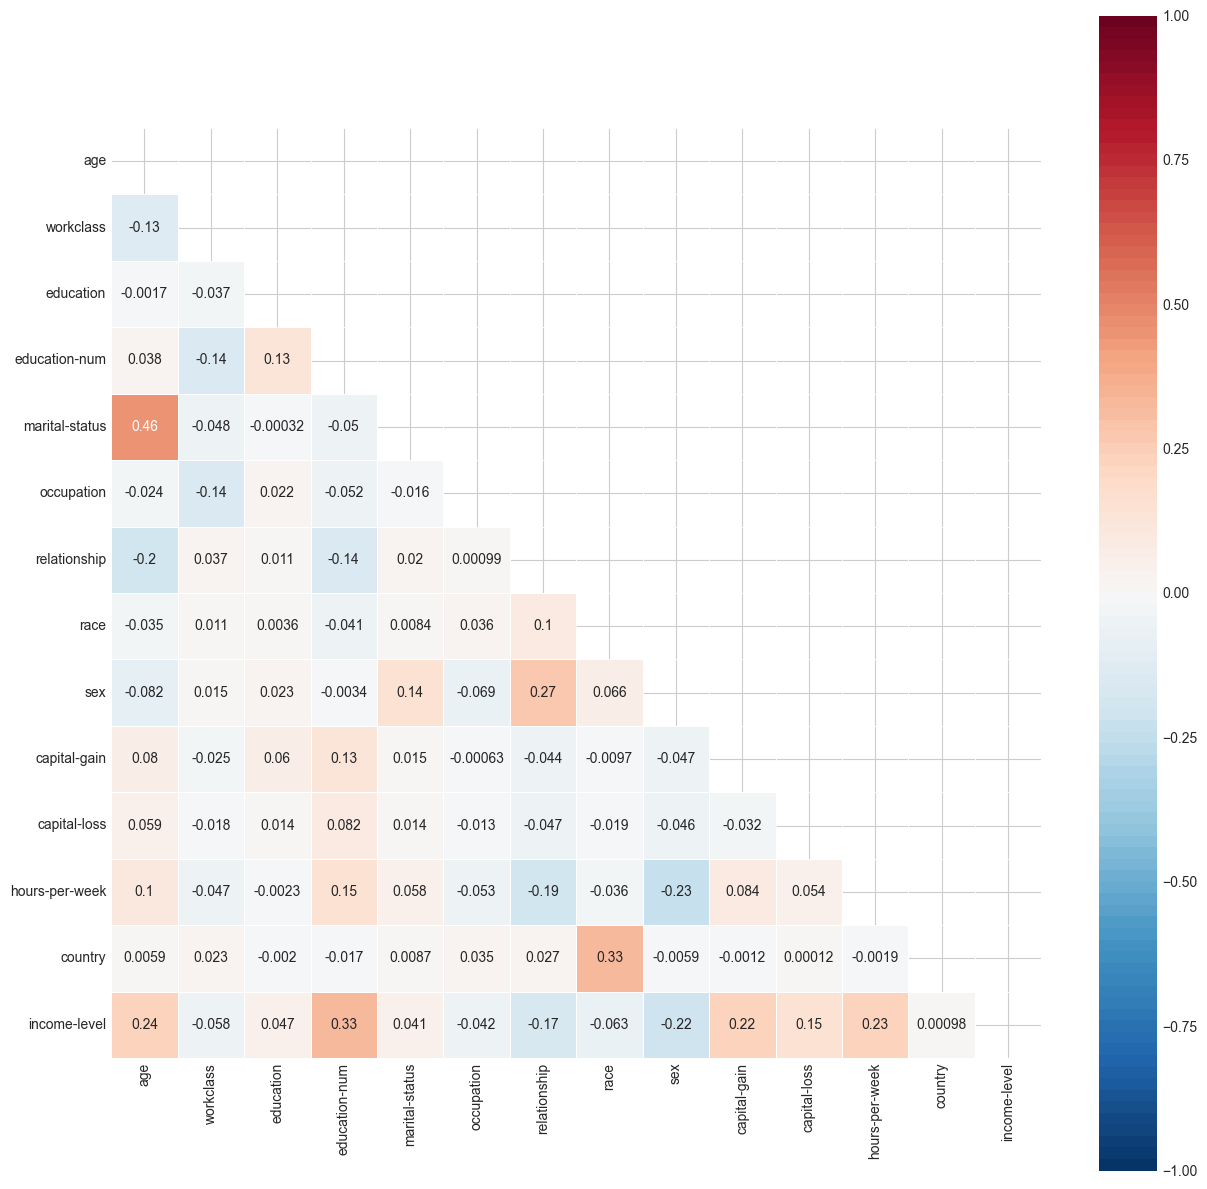

In [20]:
plt.style.use('seaborn-whitegrid')  
fig = plt.figure(figsize=(15, 15))   

mask = np.zeros_like(dataset_num.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True  
sns.heatmap(dataset_num.corr(), vmin=-1, vmax=1, square=True,   
            cmap=sns.color_palette("RdBu_r", 100),   
            mask=mask, annot=True, linewidths=.5)

# 通过相关关系分析，我们可以看出变量间没有较为明显的共线性，故不对变量进行筛选

## split dataset

1. dependent & independent
2. train & test

In [21]:
# step 1
y_data = dataset_num["income-level"]

x_data = dataset_num.drop(
    ["income-level"], axis=1
)


In [22]:
# step 2

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1, stratify=y_data
)

In [29]:
# 构造一个模型套用的样板，自动调用训练集对传入的模型进行训练
# 使用验证集对模型进行检验，并输出相关指标
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    try:
        probs = model.predict_proba(X_test)[:, 1]
    except Exception as e:
        probs = "Unavailable"
        print("Warning: Probs unavaliable.")
        print("Reason: ", e)

    acc = round(model.score(X_test, y_test) * 100, 2)
    # CV
    train_pred = model_selection.cross_val_predict(
        algo, X_train, y_train, cv=cv, n_jobs=-1
    )
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, model

In [24]:
# 汇报候选模型参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}\n".format(results["params"][candidate]))

In [25]:
# TPR(True Positive Rate)和FPR(False Positive Rate)并绘制ROC
def plot_roc_curve(y_test, preds):  
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)  
    roc_auc = metrics.auc(fpr, tpr)  
    plt.title('ROC')  
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)  
    plt.legend(loc = 'lower right')  
    plt.plot([0, 1], [0, 1],'r--')  
    plt.xlim([-0.01, 1.01])  
    plt.ylim([-0.01, 1.01])  
    plt.ylabel('TPR')  
    plt.xlabel('FPR')  
    plt.show()

In [26]:
# Precision-Recall Curve
def plot_pr_curve(y_test, probs):  
    precision, recall, _ = precision_recall_curve(y_test, probs)  
    plt.step(recall, precision, color='b', alpha=0.2,  
             where='post')  
    plt.fill_between(recall, precision, step='post', alpha=0.2,  
                     color='b')  
    plt.xlabel('Recall')  
    plt.ylabel('Precision')  
    plt.ylim([0.0, 1.05])  
    plt.xlim([0.0, 1.0])  
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(  
              average_precision_score(y_test, probs)))

# Logistic

In [27]:
# 设置超参数并构建随机搜索器
n_iter_search = 10  # 训练10次，数值越大，获得的参数精度越大，但是搜索时间越长
param_dist = {
    "penalty": ["l2", "l1"],
    "class_weight": [None, "balanced"],
    "C": np.logspace(-20, 20, 10000),
    "intercept_scaling": np.logspace(-20, 20, 10000),
}
random_search = RandomizedSearchCV(
    LogisticRegression(),  # 使用的分类器
    n_jobs=-1,  # 使用所有的CPU进行训练，默认为1，使用1个CPU
    param_distributions=param_dist,
    n_iter=n_iter_search,
)  # 训练次数
start = time.time()
random_search.fit(x_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates"
    " parameter settings." % ((time.time() - start), n_iter_search)
)
report(random_search.cv_results_)

/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

RandomizedSearchCV took 1.89 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.804 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.764068911405329e+16, 'class_weight': None, 'C': 9.938016877746389e-08}

Model with rank: 2
Mean validation score: 0.785 (std: 0.004)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.5706384792498462, 'class_weight': None, 'C': 419.04650827064955}

Model with rank: 3
Mean validation score: 0.785 (std: 0.005)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.6962111745609664e+17, 'class_weight': None, 'C': 9.63381672181646e+17}

Model with rank: 4
Mean validation score: 0.775 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.0327647353291451, 'class_weight': None, 'C': 1.3574169607006118e-13}

Model with rank: 5
Mean validation score: 0.739 (std: 0.015)
Parameters: {'penalty': 'l2', 'intercept_scaling': 34304692863149.26, 'class_weight': 'balanced', 'C': 1.1415784203737107e-05}



In [30]:
# 调用随机搜索器得到的参数最优的Logistic回归模型进行训练，
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log, model = fit_ml_algo(
    random_search.best_estimator_,
    x_train,
    y_train,
    x_test,
    10
)
log_time = time.time() - start_time
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s s" % datetime.timedelta(seconds=log_time).seconds)

Accuracy: 80.66
Accuracy CV 10-Fold: 80.44
Running Time: 0 s


In [31]:
coefficients = pd.DataFrame(
    model.coef_.flatten(), x_train.columns, columns=["Coefficient"]
)
coefficients["Odds Ratio"] = coefficients["Coefficient"].apply(lambda x: np.exp(x))

importances = coefficients.sort_values(by="Odds Ratio", ascending=False)
print(importances)

# age is the most important feature in your logistic regression model.

                Coefficient  Odds Ratio
age                0.003391    1.003396
hours-per-week     0.003121    1.003126
education-num      0.001033    1.001033
capital-loss       0.000807    1.000808
capital-gain       0.000346    1.000346
education          0.000078    1.000078
marital-status     0.000033    1.000033
country            0.000002    1.000002
workclass         -0.000049    0.999951
race              -0.000050    0.999951
occupation        -0.000067    0.999933
sex               -0.000128    0.999872
relationship      -0.000288    0.999712


In [38]:
# check the metrics on train set
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     27211
           1       0.85      0.20      0.32      8966

    accuracy                           0.79     36177
   macro avg       0.82      0.59      0.60     36177
weighted avg       0.80      0.79      0.74     36177



In [39]:
# check the metrics on test set
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      6803
           1       0.87      0.20      0.32      2242

    accuracy                           0.79      9045
   macro avg       0.83      0.59      0.60      9045
weighted avg       0.81      0.79      0.74      9045



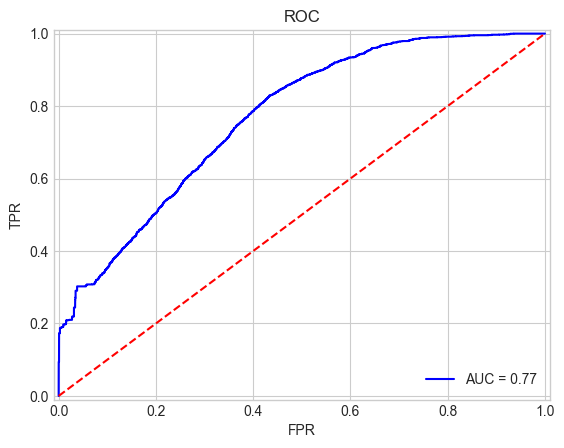

In [40]:
# ROC
plot_roc_curve(y_test, probs_log)

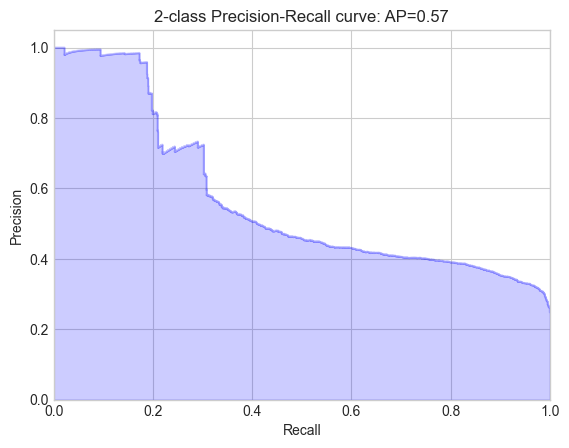

In [41]:
# P-R curve
plot_pr_curve(y_test, probs_log)

# KNN

In [34]:
# k-Nearest Neighbors  
start_time = time.time()  
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn, model = fit_ml_algo(
  KNeighborsClassifier(
    n_neighbors = 3,  
    n_jobs = -1
  ),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
knn_time = (time.time() - start_time)  
print("Accuracy: %s" % acc_knn)  
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)  
print("Running Time: %s s" % datetime.timedelta(seconds=knn_time))  



Accuracy: 82.81
Accuracy CV 10-Fold: 82.6
Running Time: 0:00:02.133638 s


In [38]:
from sklearn.inspection import permutation_importance

# Permutation Feature Importance
perm_importance = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42
)
perm_importance_df = pd.DataFrame(
    perm_importance.importances_mean,
    index=x_train.columns,
    columns=["Importance"]
)

# Sort and display feature importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)
print(perm_importance_df)

                Importance
capital-gain      0.057700
education-num     0.032681
age               0.027772
capital-loss      0.025738
hours-per-week    0.012836
relationship      0.010426
marital-status    0.007242
education         0.005296
occupation        0.004820
workclass         0.000884
race             -0.000265
sex              -0.001183
country          -0.001327


In [43]:
# check the metrics on train set

print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     27211
           1       0.66      0.63      0.64      8966

    accuracy                           0.83     36177
   macro avg       0.77      0.76      0.76     36177
weighted avg       0.82      0.83      0.82     36177



In [44]:
# check the metrics on test set

print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6803
           1       0.66      0.64      0.65      2242

    accuracy                           0.83      9045
   macro avg       0.77      0.76      0.77      9045
weighted avg       0.83      0.83      0.83      9045



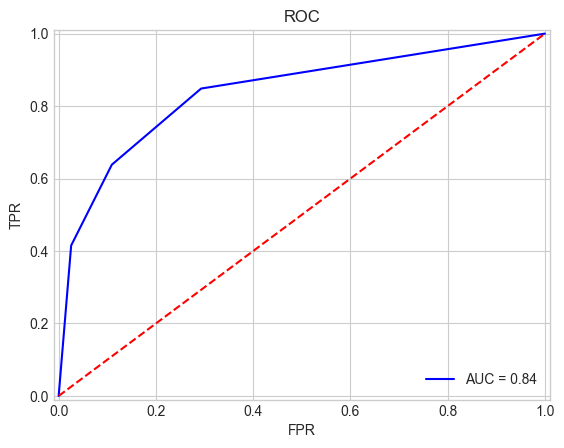

In [45]:
plot_roc_curve(y_test, probs_knn)

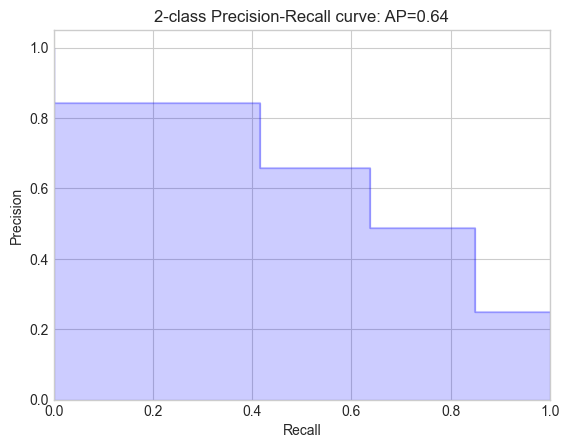

In [46]:
plot_pr_curve(y_test, probs_knn)

# Gaussian Naive Bayes  

In [40]:
start_time = time.time()  
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau, model = fit_ml_algo(
  GaussianNB(),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
gaussian_time = (time.time() - start_time)  

print("Accuracy: %s" % acc_gaussian)  
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)  
print("Running Time: %s s" % datetime.timedelta(seconds=gaussian_time).seconds) 


Accuracy: 80.19
Accuracy CV 10-Fold: 79.88
Running Time: 0 s


In [41]:
from sklearn.inspection import permutation_importance

# Permutation Feature Importance
perm_importance = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42
)
perm_importance_df = pd.DataFrame(
    perm_importance.importances_mean, index=x_train.columns, columns=["Importance"]
)

# Sort and display feature importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)
print(perm_importance_df)

                Importance
capital-gain      0.058861
capital-loss      0.025893
education-num     0.007020
education         0.005616
relationship      0.003195
marital-status    0.003173
sex               0.002300
age               0.002289
hours-per-week    0.001769
country           0.001128
workclass         0.000586
occupation        0.000155
race             -0.000221


In [48]:
# check the metrics on train set

print(metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     27211
           1       0.69      0.35      0.46      8966

    accuracy                           0.80     36177
   macro avg       0.75      0.65      0.67     36177
weighted avg       0.78      0.80      0.77     36177



In [49]:
# check the metrics on test set

print(metrics.classification_report(y_test, test_pred_gaussian))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      6803
           1       0.70      0.35      0.47      2242

    accuracy                           0.80      9045
   macro avg       0.76      0.65      0.67      9045
weighted avg       0.79      0.80      0.78      9045



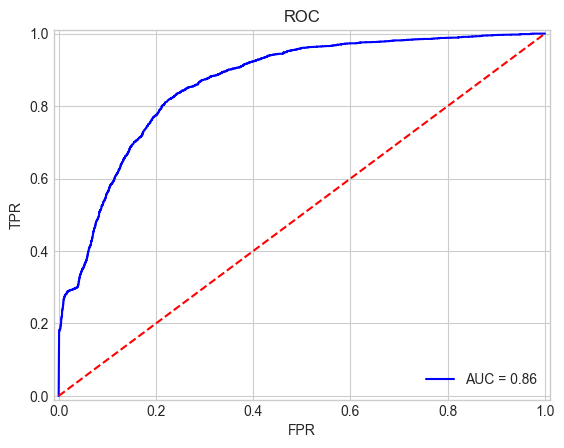

In [50]:
plot_roc_curve(y_test, probs_gau)

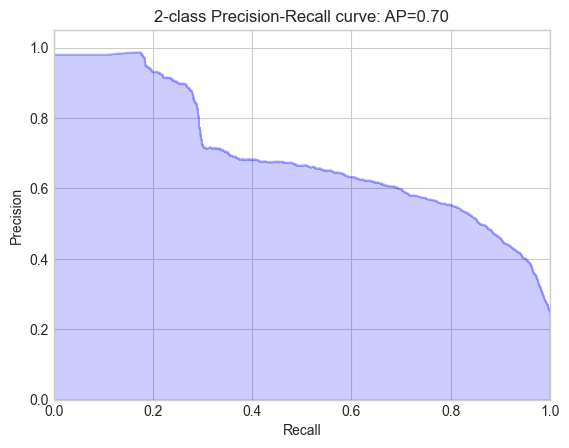

In [51]:
plot_pr_curve(y_test, probs_gau)

# SVC
向量机

In [42]:
# Linear SVC  
start_time = time.time()  

# kernel = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’  
svc_clf = SVC(probability=True, max_iter=1000, kernel='linear')  
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, probs_svc, model = fit_ml_algo(
  svc_clf,  
  x_train,   
  y_train,  
  x_test,   
  10
)  
linear_svc_time = (time.time() - start_time)  

print("Accuracy: %s" % acc_linear_svc)  
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)  
print("Running Time: %s s" % datetime.timedelta(seconds=linear_svc_time).seconds)  



/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jiaronghe/.py

Accuracy: 53.29
Accuracy CV 10-Fold: 35.68
Running Time: 5 s


/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [43]:
from sklearn.inspection import permutation_importance

# Permutation Feature Importance
perm_importance = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42
)
perm_importance_df = pd.DataFrame(
    perm_importance.importances_mean, index=x_train.columns, columns=["Importance"]
)

# Sort and display feature importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)
print(perm_importance_df)

                Importance
age               0.095998
occupation        0.003460
race              0.003140
hours-per-week    0.002465
workclass         0.000509
sex               0.000409
marital-status    0.000398
education         0.000332
country           0.000011
relationship     -0.000066
education-num    -0.001404
capital-loss     -0.016661
capital-gain     -0.039668


In [53]:
print(metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

           0       0.68      0.28      0.39     27211
           1       0.21      0.59      0.31      8966

    accuracy                           0.36     36177
   macro avg       0.44      0.44      0.35     36177
weighted avg       0.56      0.36      0.37     36177



In [54]:
print(metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

           0       0.79      0.52      0.63      6803
           1       0.28      0.58      0.38      2242

    accuracy                           0.53      9045
   macro avg       0.54      0.55      0.50      9045
weighted avg       0.66      0.53      0.56      9045



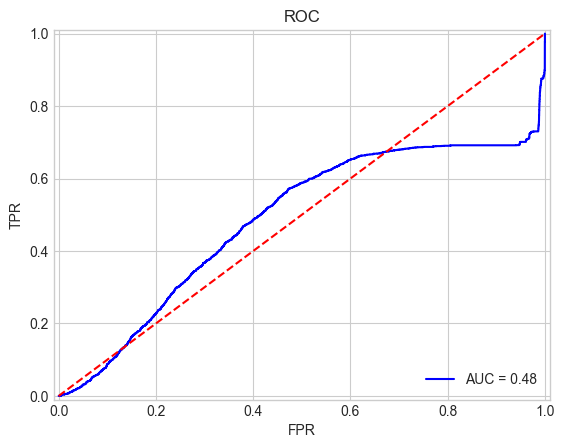

In [55]:
plot_roc_curve(y_test, probs_svc)

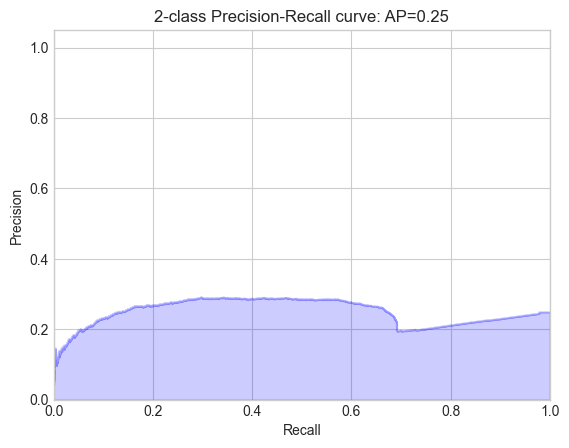

In [56]:
plot_pr_curve(y_test, probs_svc)

# SGD

Stochastic Gradient Descent

In [44]:
start_time = time.time()  

# among {'modified_huber', 'perceptron', 'squared_hinge', 'squared_error', 'hinge', 'huber', 'squared_epsilon_insensitive', 'log_loss', 'epsilon_insensitive'}
# => using "log_loss"
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, probs_sgd, model = fit_ml_algo(  
  SGDClassifier(n_jobs = -1, loss='log_loss'),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
sgd_time = (time.time() - start_time) 


print("Accuracy: %s" % acc_sgd)  
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)  
print("Running Time: %s s" % datetime.timedelta(seconds=sgd_time).seconds)  

Accuracy: 77.35
Accuracy CV 10-Fold: 77.78
Running Time: 0 s


In [45]:
# Extract feature importance (coefficients)
coefficients = pd.DataFrame(model.coef_.flatten(), x_train.columns, columns=["Coefficient"])
coefficients["Absolute Coefficient"] = coefficients["Coefficient"].apply(np.abs)

importances = coefficients.sort_values(by="Absolute Coefficient", ascending=False)
print(importances)

                Coefficient  Absolute Coefficient
capital-gain     397.270963            397.270963
sex              -45.113202             45.113202
education-num     27.394266             27.394266
workclass         24.356317             24.356317
race              -5.410884              5.410884
age                3.847479              3.847479
hours-per-week     3.324235              3.324235
capital-loss       3.257042              3.257042
relationship       2.808915              2.808915
education          2.030915              2.030915
occupation         1.474454              1.474454
country           -0.942619              0.942619
marital-status    -0.376355              0.376355


In [59]:
print(metrics.classification_report(y_train, train_pred_sgd))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     27211
           1       0.55      0.47      0.51      8966

    accuracy                           0.77     36177
   macro avg       0.69      0.67      0.68     36177
weighted avg       0.76      0.77      0.77     36177



In [60]:
print(metrics.classification_report(y_test, test_pred_sgd))

              precision    recall  f1-score   support

           0       0.87      0.79      0.82      6803
           1       0.49      0.63      0.55      2242

    accuracy                           0.75      9045
   macro avg       0.68      0.71      0.69      9045
weighted avg       0.77      0.75      0.76      9045



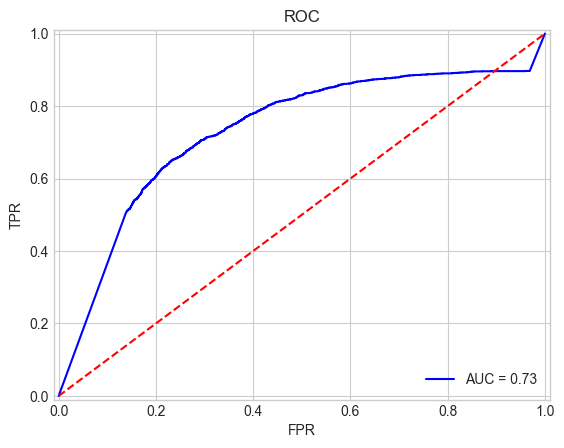

In [61]:
plot_roc_curve(y_test, probs_sgd)

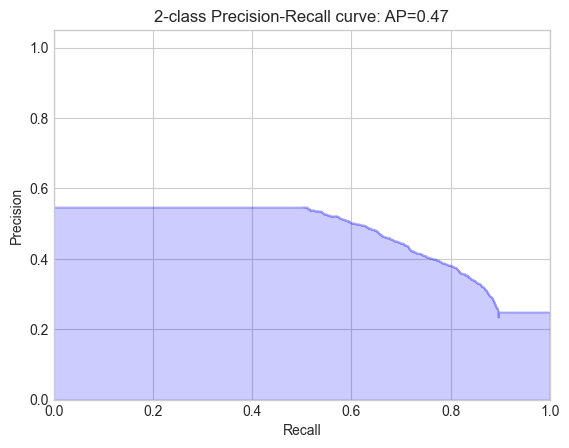

In [62]:
plot_pr_curve(y_test, probs_sgd)

# Decision Tree

In [46]:
start_time = time.time()  
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, model = fit_ml_algo(
  DecisionTreeClassifier(),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
dt_time = (time.time() - start_time)  

print("Accuracy: %s" % acc_dt)  
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)  
print("Running Time: %s s" % datetime.timedelta(seconds=dt_time).seconds)

Accuracy: 82.28
Accuracy CV 10-Fold: 81.77
Running Time: 0 s


In [47]:
feature_importance = pd.DataFrame(
    model.feature_importances_, index=x_train.columns, columns=["Importance"]
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                Importance
capital-gain      0.188570
age               0.180111
marital-status    0.172911
education-num     0.133984
hours-per-week    0.104798
capital-loss      0.047680
occupation        0.045315
workclass         0.042436
race              0.020555
country           0.019146
education         0.016557
relationship      0.015246
sex               0.012691


In [64]:
print(metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     27211
           1       0.64      0.60      0.62      8966

    accuracy                           0.82     36177
   macro avg       0.75      0.75      0.75     36177
weighted avg       0.81      0.82      0.82     36177



In [65]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6803
           1       0.65      0.61      0.63      2242

    accuracy                           0.82      9045
   macro avg       0.76      0.75      0.76      9045
weighted avg       0.82      0.82      0.82      9045



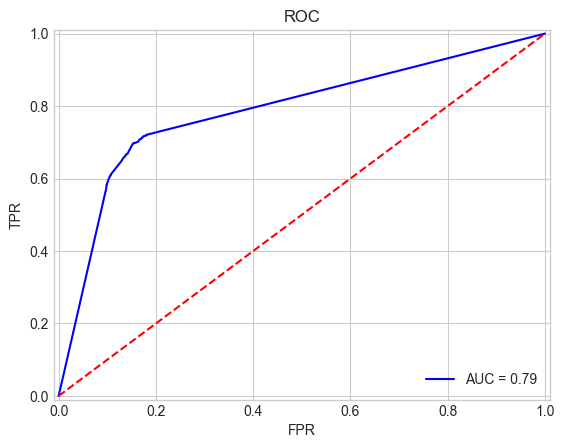

In [66]:
plot_roc_curve(y_test, probs_dt)

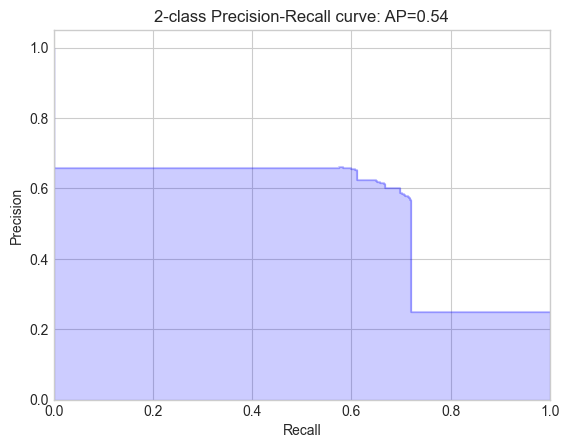

In [67]:
plot_pr_curve(y_test, probs_dt)

# Random forest

In [48]:
# 从中调参的超参数集合
param_dist = {
    "max_depth": [10, None],
    "max_features": sp_randint(1, 11),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

# Run Randomized Search
n_iter_search = 10
random_search = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=10),
    n_jobs=-1,
    param_distributions=param_dist,
    n_iter=n_iter_search,
)

start = time.time()
random_search.fit(x_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates"
    " parameter settings." % ((time.time() - start), n_iter_search)
)
report(random_search.cv_results_)

RandomizedSearchCV took 1.73 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.857 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: 0.855 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 19}

Model with rank: 3
Mean validation score: 0.855 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 6}

Model with rank: 4
Mean validation score: 0.854 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 3}

Model with rank: 5
Mean validation score: 0.854 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'm

In [49]:
# 使用随机搜索器算得的最优超参数模型进行计算
start_time = time.time()
rfc = random_search.best_estimator_
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf, model = fit_ml_algo(
    rfc, x_train, y_train, x_test, 10
)
rf_time = time.time() - start_time

print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s s" % datetime.timedelta(seconds=rf_time).seconds)

Accuracy: 86.15
Accuracy CV 10-Fold: 85.63
Running Time: 0 s


In [50]:
# Extract feature importance
feature_importance = pd.DataFrame(
    model.feature_importances_, index=x_train.columns, columns=["Importance"]
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                Importance
capital-gain      0.287130
education-num     0.183214
marital-status    0.176932
relationship      0.159523
capital-loss      0.069709
age               0.045658
hours-per-week    0.026942
education         0.023465
occupation        0.016573
sex               0.006559
workclass         0.002622
country           0.001299
race              0.000373


In [70]:
print(metrics.classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27211
           1       0.77      0.59      0.67      8966

    accuracy                           0.86     36177
   macro avg       0.83      0.77      0.79     36177
weighted avg       0.85      0.86      0.85     36177



In [71]:
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6803
           1       0.79      0.60      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.83      0.78      0.80      9045
weighted avg       0.86      0.86      0.86      9045



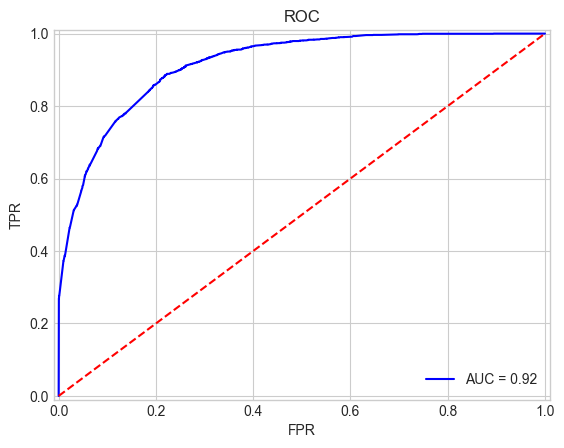

In [72]:
plot_roc_curve(y_test, probs_rf)

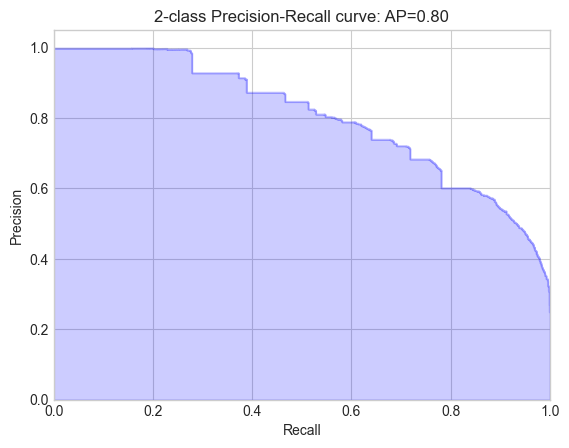

In [73]:
plot_pr_curve(y_test, probs_rf)

# Gradient Boosting Trees

In [51]:
start_time = time.time()  
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt, model = fit_ml_algo(   
  GradientBoostingClassifier(),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
gbt_time = (time.time() - start_time)  

print("Accuracy: %s" % acc_gbt)  
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)  
print("Running Time: %s s" % datetime.timedelta(seconds=gbt_time).seconds)

Accuracy: 86.2
Accuracy CV 10-Fold: 85.94
Running Time: 4 s


In [52]:
# Extract feature importance
feature_importance = pd.DataFrame(
    model.feature_importances_, index=x_train.columns, columns=["Importance"]
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                Importance
capital-gain      0.274548
marital-status    0.208050
education-num     0.187860
relationship      0.134120
capital-loss      0.065947
age               0.060839
hours-per-week    0.037218
occupation        0.019522
education         0.004539
sex               0.003523
workclass         0.002932
country           0.000634
race              0.000268


In [75]:
print(metrics.classification_report(y_train, train_pred_gbt))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27211
           1       0.79      0.59      0.68      8966

    accuracy                           0.86     36177
   macro avg       0.83      0.77      0.79     36177
weighted avg       0.85      0.86      0.85     36177



In [76]:
print(metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6803
           1       0.81      0.58      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.84      0.77      0.79      9045
weighted avg       0.86      0.86      0.85      9045



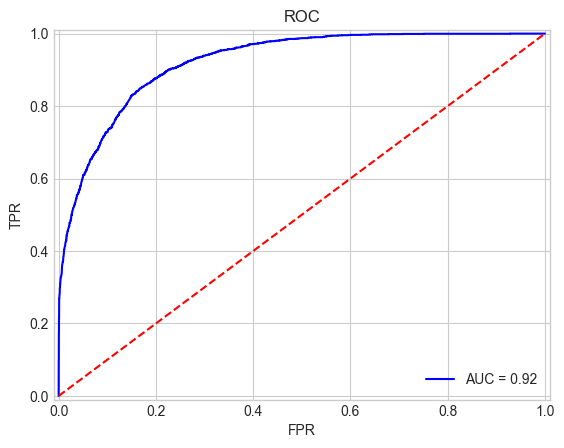

In [77]:
plot_roc_curve(y_test, probs_gbt)

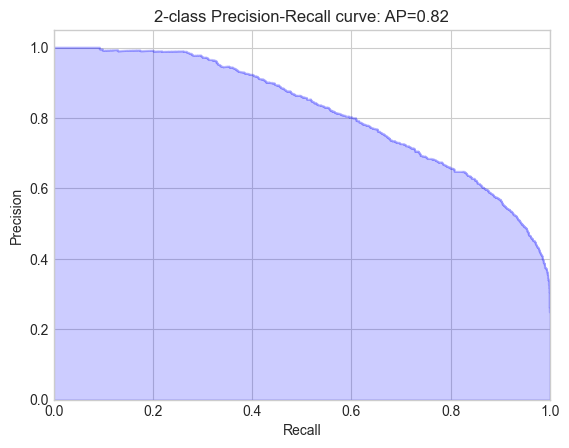

In [78]:
plot_pr_curve(y_test, probs_gbt)

# AdaBoost

In [53]:
start_time = time.time()  
train_pred_adb, test_pred_adb, acc_adb, acc_cv_adb, probs_adb, model = fit_ml_algo(
  AdaBoostClassifier(),   
  x_train,   
  y_train,   
  x_test,   
  10
)  
adb_time = (time.time() - start_time)  

print("Accuracy: %s" % acc_adb)  
print("Accuracy CV 10-Fold: %s" % acc_cv_adb)  
print("Running Time: %s s" % datetime.timedelta(seconds=adb_time).seconds)


Accuracy: 85.86
Accuracy CV 10-Fold: 85.41
Running Time: 1 s


In [54]:
# Extract feature importance
feature_importance = pd.DataFrame(
    model.feature_importances_, index=x_train.columns, columns=["Importance"]
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                Importance
capital-loss          0.20
capital-gain          0.18
age                   0.16
occupation            0.12
education-num         0.10
hours-per-week        0.06
education             0.04
marital-status        0.04
relationship          0.04
workclass             0.02
race                  0.02
sex                   0.02
country               0.00


In [80]:
print(metrics.classification_report(y_train, train_pred_adb))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27211
           1       0.76      0.60      0.67      8966

    accuracy                           0.85     36177
   macro avg       0.82      0.77      0.79     36177
weighted avg       0.85      0.85      0.85     36177



In [81]:
print(metrics.classification_report(y_test, test_pred_adb))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6803
           1       0.77      0.62      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.78      0.80      9045
weighted avg       0.85      0.86      0.85      9045



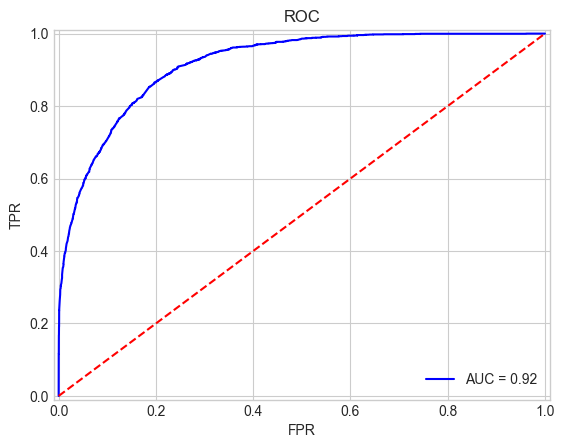

In [82]:
plot_roc_curve(y_test, probs_adb)

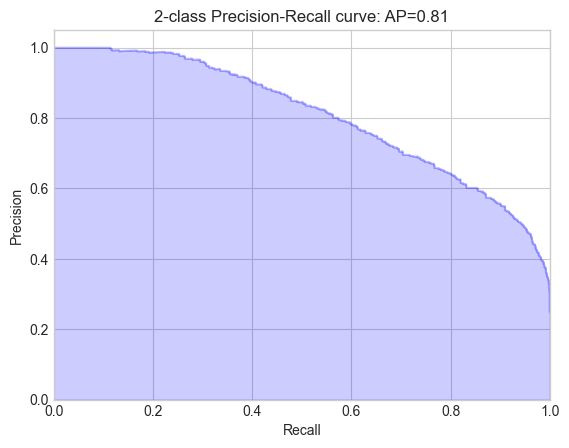

In [83]:
plot_pr_curve(y_test, probs_adb)

# Voting Classifier

1. Soft Voting (perform better)
2. Majority/Hard voting

- Logistic
- Gaussian Native Bayes
- random forest
- gradient boosting
- decision tree


In [84]:
start_time = time.time()  
voting_clf = VotingClassifier(estimators=[  
    ('log_clf', LogisticRegression()),   
    ('gnb_clf', GaussianNB()),  
    ('rf_clf', RandomForestClassifier(n_estimators=10)),  
    ('gb_clf', GradientBoostingClassifier()),  
    ('dt_clf', DecisionTreeClassifier(random_state=666))],  
                             voting='soft', n_jobs = -1)  
train_pred_vot, test_pred_vot, acc_vot, acc_cv_vot, probs_vot = fit_ml_algo(
  voting_clf,   
  x_train,   
  y_train,   
  x_test,   
  10
)  
vot_time = (time.time() - start_time)  
print("Accuracy: %s" % acc_vot)  
print("Accuracy CV 10-Fold: %s" % acc_cv_vot)  
print("Running Time: %s s" % datetime.timedelta(seconds=vot_time).seconds)

/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Accuracy: 84.67
Accuracy CV 10-Fold: 84.53
Running Time: 4 s


In [85]:
print(metrics.classification_report(y_train, train_pred_vot))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     27211
           1       0.79      0.51      0.62      8966

    accuracy                           0.85     36177
   macro avg       0.82      0.73      0.76     36177
weighted avg       0.84      0.85      0.83     36177



In [86]:
print(metrics.classification_report(y_test, test_pred_vot))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6803
           1       0.79      0.52      0.63      2242

    accuracy                           0.85      9045
   macro avg       0.82      0.74      0.76      9045
weighted avg       0.84      0.85      0.83      9045



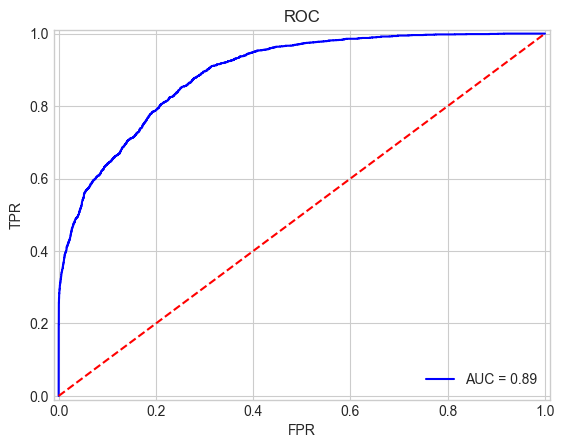

In [87]:
plot_roc_curve(y_test, probs_vot)

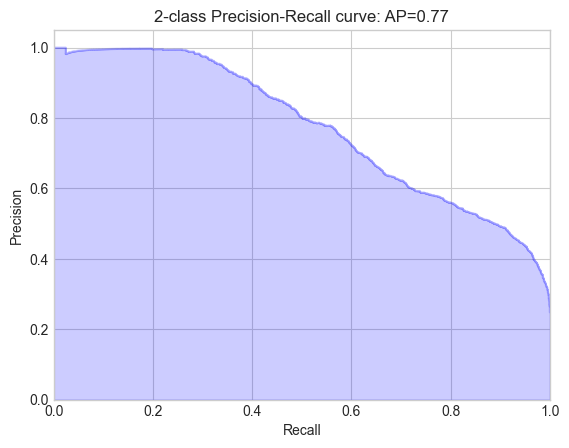

In [88]:
plot_pr_curve(y_test, probs_vot)

# Accuracy / Precision / Recall / F1

本文最终选用准确率（Accuracy）、精确率（Precision）、召回率（Recall）、F1分数、作为主要的评价指标。

准确率（Accuracy）表示分类模型所有判断正确的结果占总观测值的比重；
精确率（Precision）表示模型观测是Positive的所有结果中，模型预测对的比重；
召回率（Recall）表示真实值是Positive的所有结果中，模型预测对的比重；
F1分数综合了Precision和Recall的结果，是精确率和召回率的调和平均数，取值越高，模型效果越好.

In [89]:
models = pd.DataFrame(
    {
        "Model": [
            "KNN",
            "Logistic Regression",
            "Random Forest",
            "Naive Bayes",
            "Stochastic Gradient Decent",
            "Linear SVC",
            "Decision Tree",
            "Gradient Boosting Trees",
            "AdaBoost",
            "Voting",
        ],
        "Acc": [
            acc_knn,
            acc_log,
            acc_rf,
            acc_gaussian,
            acc_sgd,
            acc_linear_svc,
            acc_dt,
            acc_gbt,
            acc_adb,
            acc_vot,
        ],
        "Acc_cv": [
            acc_cv_knn,
            acc_cv_log,
            acc_cv_rf,
            acc_cv_gaussian,
            acc_cv_sgd,
            acc_cv_linear_svc,
            acc_cv_dt,
            acc_cv_gbt,
            acc_cv_adb,
            acc_cv_vot,
        ],
        "precision": [
            round(precision_score(y_test, test_pred_knn), 3),
            round(precision_score(y_test, test_pred_log), 3),
            round(precision_score(y_test, test_pred_rf), 3),
            round(precision_score(y_test, test_pred_gaussian), 3),
            round(precision_score(y_test, test_pred_sgd), 3),
            round(precision_score(y_test, test_pred_svc), 3),
            round(precision_score(y_test, test_pred_dt), 3),
            round(precision_score(y_test, test_pred_gbt), 3),
            round(precision_score(y_test, test_pred_adb), 3),
            round(precision_score(y_test, test_pred_vot), 3),
        ],
        "recall": [
            round(recall_score(y_test, test_pred_knn), 3),
            round(recall_score(y_test, test_pred_log), 3),
            round(recall_score(y_test, test_pred_rf), 3),
            round(recall_score(y_test, test_pred_gaussian), 3),
            round(recall_score(y_test, test_pred_sgd), 3),
            round(recall_score(y_test, test_pred_svc), 3),
            round(recall_score(y_test, test_pred_dt), 3),
            round(recall_score(y_test, test_pred_gbt), 3),
            round(recall_score(y_test, test_pred_adb), 3),
            round(recall_score(y_test, test_pred_vot), 3),
        ],
        "F1": [
            round(f1_score(y_test, test_pred_knn, average="binary"), 3),
            round(f1_score(y_test, test_pred_log, average="binary"), 3),
            round(f1_score(y_test, test_pred_rf, average="binary"), 3),
            round(f1_score(y_test, test_pred_gaussian, average="binary"), 3),
            round(f1_score(y_test, test_pred_sgd, average="binary"), 3),
            round(f1_score(y_test, test_pred_svc, average="binary"), 3),
            round(f1_score(y_test, test_pred_dt, average="binary"), 3),
            round(f1_score(y_test, test_pred_gbt, average="binary"), 3),
            round(f1_score(y_test, test_pred_adb, average="binary"), 3),
            round(f1_score(y_test, test_pred_vot, average="binary"), 3),
        ],
    }
)
models.sort_values(by="Acc", ascending=False)

,Model,Acc,Acc_cv,precision,recall,F1
7,Gradient Boosting Trees,86.20,85.94,0.808,0.581,0.676
2,Random Forest,86.18,85.67,0.788,0.605,0.685
8,AdaBoost,85.86,85.41,0.766,0.618,0.684
9,Voting,84.67,84.53,0.791,0.518,0.626
0,KNN,82.81,82.60,0.658,0.638,0.648
6,Decision Tree,82.29,81.70,0.652,0.612,0.631
3,Naive Bayes,80.19,79.88,0.702,0.349,0.466
1,Logistic Regression,79.38,79.28,0.870,0.198,0.322
4,Stochastic Gradient Decent,74.70,77.44,0.492,0.628,0.552
5,Linear SVC,53.29,35.68,0.283,0.576,0.379


- 梯度提升决策树（Gradient Boosting Trees）、AdaBoost、随机森林（Random Forest）三个模型的准确率均表现良好，达到了85%以上，

- F1值相较于其他模型也处于较为优秀的水平，故从指标角度来看，这三个模型更适用于本文所研究的问题

# ROC

ROC曲线全称Receiver Operating Characteristic Curve，即接受者操作特征曲线，ROC曲线越接近左上角，其对应模型的分类效果越好。参数AUC（Area Under Curve）代表了ROC曲线下的面积，能够定量地衡量分类器的好坏，AUC值越大，模型表现效果越好

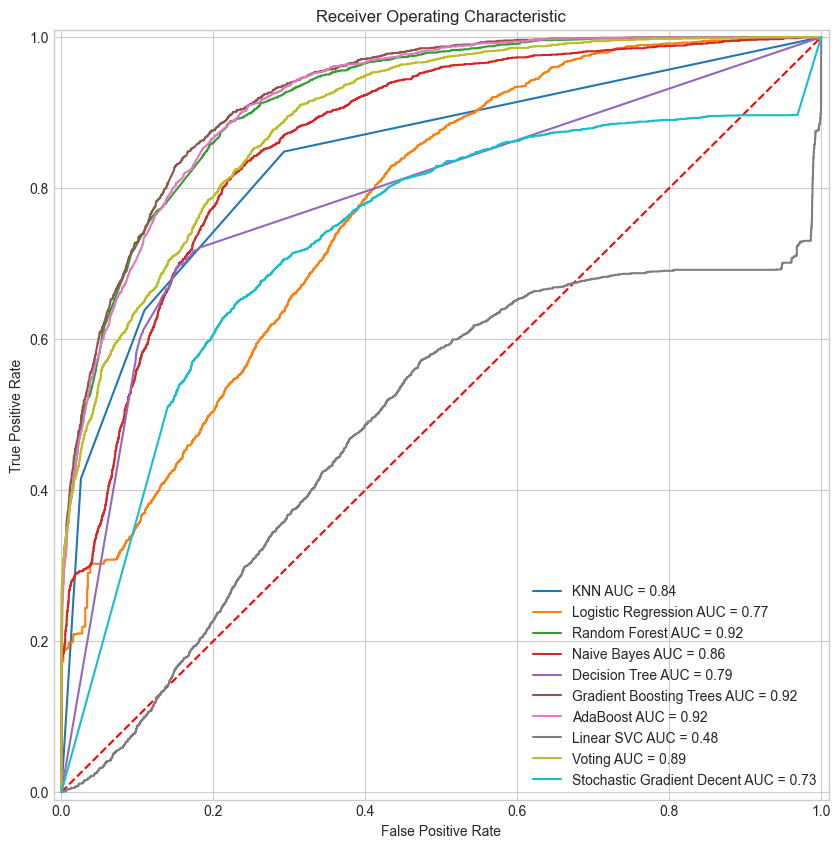

In [90]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(10, 10))
models = [
    "KNN",
    "Logistic Regression",
    "Random Forest",
    "Naive Bayes",
    "Decision Tree",
    "Gradient Boosting Trees",
    "AdaBoost",
    "Linear SVC",
    "Voting",
    "Stochastic Gradient Decent",
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt,
    probs_adb,
    probs_svc,
    probs_vot,
    probs_sgd,
]
colormap = plt.cm.tab10  # nipy_spectral, Set1, Paired, tab10, gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1, len(models))]
plt.title("Receiver Operating Characteristic")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    label = model + " AUC = %0.2f" % roc_auc
    plt.plot(fpr, tpr, "b", label=label, color=colors[i])
    plt.legend(loc="lower right")


for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])

- 对比AUC值，本文中梯度提升决策树（Gradient Boosting Trees）和AdaBoost两个模型表现最优，AUC值均达到了0.92，

- 线性支持向量机模型表现最差，几乎无法起到有效的分类作用

# P-R curve

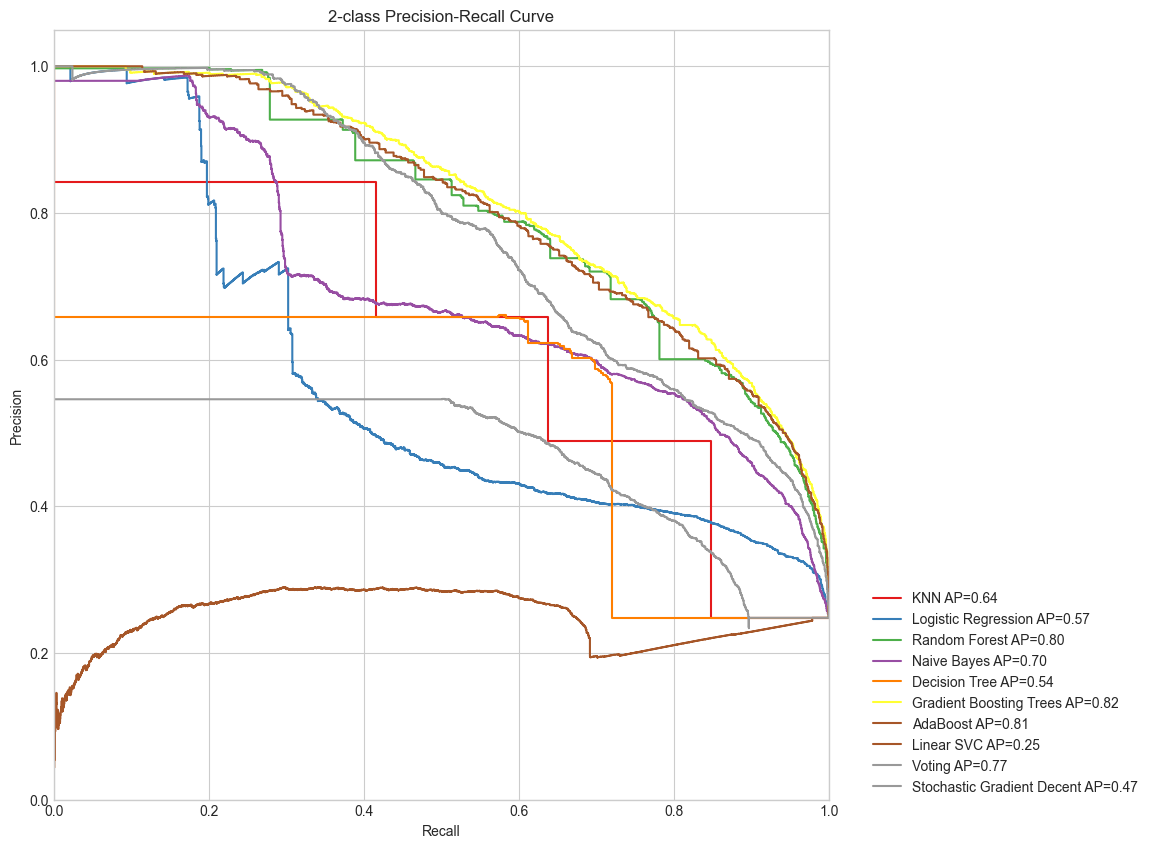

In [91]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class Precision-Recall Curve")
colormap = plt.cm.Set1  # nipy_spectral, Set1, Paired, gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1, len(models))]


def plot_pr_curve_overall(y_test, probs, model):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    label = model + " AP={0:0.2f}".format(average_precision_score(y_test, probs))
    plt.step(recall, precision, color=colors[i], where="post", label=label)
    #     plt.fill_between(recall, precision, step='post', alpha=0.2, color=colors[i])
    plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


for i, model in list(enumerate(models)):
    plot_pr_curve_overall(y_test, probs[i], models[i])

P-R曲线可以看出，梯度提升决策树分类器的表现效果最好，其次为AdaBoost和随机森林，与ROC曲线和观察相关评价指标得出的结果大致一致。